# Test models performences

2025-06-15 18:39:17.523204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750001957.531281   96653 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750001957.533672   96653 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750001957.539744   96653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750001957.539753   96653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750001957.539754   96653 computation_placer.cc:177] computation placer alr

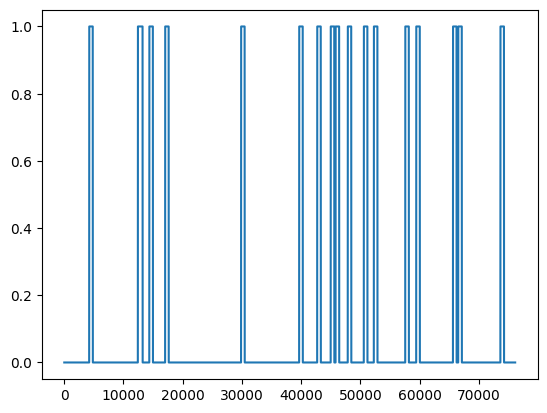

In [1]:
# import modules and load data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load input and output data
X = np.load("../data/processed/input.npy")
Y = np.load("../data/processed/output.npy")

# TODO: Custom shuffle for RNN model
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(X, Y, test_size=0.15, shuffle=False)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_train_s, y_train_s, test_size=0.18, shuffle=False)

# 15% test
# 15% validation
# 70% train

plt.plot(range(len(y_test_s)), y_test_s)
plt.show()

#### Model 1

In [2]:
from sklearn.utils import class_weight
from model import create_sequences

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Number of frames fed into the LSTM layer at one time
sequence_length = 30 * 3  # fps * seconds

# The max number of neurons in the LSTM/RNN layer (min 16)
max_layer_neurons = 1024

# Reshape the data from (n, 14) to (n, sequence_length, 14)
x_train, y_train = create_sequences(x_train_s, y_train_s, sequence_length)
x_val, y_val = create_sequences(x_val_s, y_val_s, sequence_length)
x_test, y_test = create_sequences(x_test_s, y_test_s, sequence_length)

# Adapt the normlizer layer to the feature axis in the input data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x_train)

# Define the model 
model = tf.keras.Sequential([
    layers.Input((sequence_length,14)),
    normalizer,
    # layers.SimpleRNN(1024, input_shape=(1,14) ,return_sequences=False),  # or use LSTM
    layers.LSTM(max_layer_neurons, recurrent_dropout=0.1, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(max_layer_neurons//2, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(max_layer_neurons//4, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(max_layer_neurons//8, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # Output a single scalar
])

# Add more metrices!
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Penalize the model more for misclassifying the minority class using class weight
# Calculate the class weights
weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
# weights = 1/weights # Inverse popularity to weight
class_weights = dict(zip(np.unique(y_train), weights))


print("Calculated Class Weights:", class_weights)


# 1. Configure the EarlyStopping callback
# This will monitor the validation loss and stop training if it doesn't improve.
early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to watch
    patience=4,          # How many epochs to wait for improvement before stopping
    min_delta=0.01,     # Minimum change in the monitored quantity to qualify as an improvement
    mode='min',          # We want the 'val_loss' to decrease, so we use 'min' mode
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)


# Train model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=400, class_weight=class_weights, callbacks=early_stopping)


I0000 00:00:1750001960.484287   96653 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Calculated Class Weights: {np.float64(0.0): np.float64(0.6684513622276701), np.float64(1.0): np.float64(1.984107915150683)}


2025-06-15 18:39:24.805383: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1748023200 exceeds 10% of free system memory.
2025-06-15 18:39:26.082085: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1748023200 exceeds 10% of free system memory.


Epoch 1/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 367s 420ms/step - accuracy: 0.6928 - loss: 1.0082 - val_accuracy: 0.5586 - val_loss: 0.7241
Epoch 2/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 352s 406ms/step - accuracy: 0.7351 - loss: 0.6954 - val_accuracy: 0.6864 - val_loss: 0.6854
Epoch 3/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 352s 405ms/step - accuracy: 0.7556 - loss: 0.5461 - val_accuracy: 0.6481 - val_loss: 0.6135
Epoch 4/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 351s 405ms/step - accuracy: 0.7787 - loss: 0.4596 - val_accuracy: 0.5903 - val_loss: 0.7140
Epoch 5/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 353s 406ms/step - accuracy: 0.7898 - loss: 0.4416 - val_accuracy: 0.5493 - val_loss: 0.7393
Epoch 6/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 358s 413ms/step - accuracy: 0.8040 - loss: 0.4178 - val_accuracy: 0.4306 - val_loss: 0.9123
Epoch 7/20
868/868 ━━━━━━━━━━━━━━━━━━━━ 377s 434ms/step - accuracy: 0.8213 - loss: 0.3854 - val_accuracy: 0.4611 - val_loss: 0.9896


## Test Performences

==== MODEL #1 ====
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 237s 99ms/step
Probability Plot:


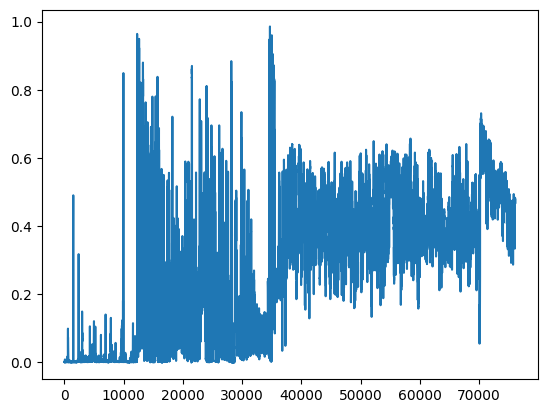

Predition/Test Plot:


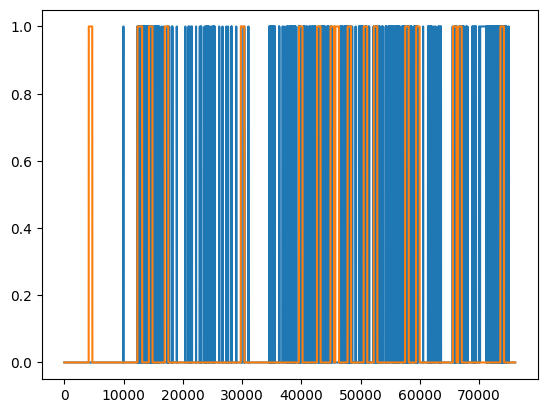

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85     65629
         1.0       0.17      0.20      0.18     10435

    accuracy                           0.75     76064
   macro avg       0.52      0.52      0.52     76064
weighted avg       0.77      0.75      0.76     76064



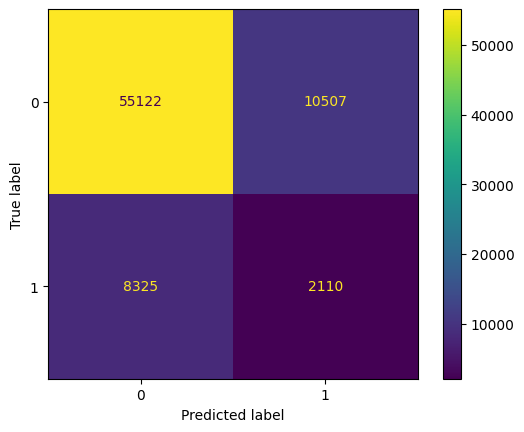

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# Model 1
print("==== MODEL #1 ====")

# Predict probabilities
y1_prob = model.predict(x_test)

# Convert probabilities to binary predictions (> 50% for positive prediction)
y1_pred = (y1_prob >= 0.5).astype(int).squeeze() 

# Confusion Matrix
cm1 = confusion_matrix(y_test, y1_pred)
disp1 = ConfusionMatrixDisplay(cm1)

print("Probability Plot:")
plt.plot(range(len(y1_prob)), y1_prob)
plt.show()

print("Predition/Test Plot:")
plt.plot(range(len(y1_pred)), y1_pred, y_test)
plt.show()

# Classification Report
report1 = classification_report(y_test, y1_pred)

disp1.plot()
print("Classification Report:\n", report1)



==== High-Pass Filtered Signal vs. Ground Truth Analysis ====



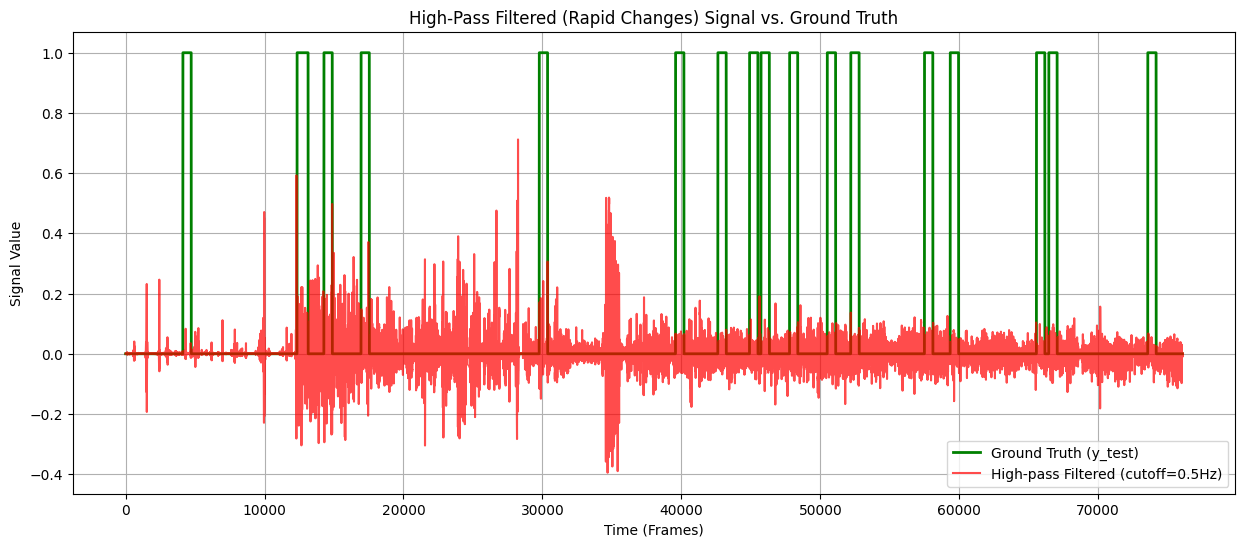


==== High-Pass Filtered Signal Performance Analysis ====

This section tests if the *rapid increase* in probability is a better predictor.
Best F1-Score for High-Pass Signal: 0.2154
Found at threshold: 0.01

==== Classification Report with High-Pass Filter Optimal Threshold ====

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79     65629
         1.0       0.16      0.33      0.22     10435

    accuracy                           0.67     76064
   macro avg       0.52      0.53      0.50     76064
weighted avg       0.77      0.67      0.71     76064



In [5]:
from sklearn.metrics import classification_report, f1_score
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt




# --- SECTION 2: Analyze High-Pass Filtered Signal vs. Ground Truth ---

# Squeeze the probability array to 1D for filtering
y_prob_signal = y_prob.squeeze()

# Filter design parameters
fs = 30  # Sampling frequency (assuming 30 fps video)
order = 5 # Filter order
high_cutoff = 0.5 # Hz

# High-pass filter to isolate rapid changes in probability
b_high, a_high = signal.butter(order, high_cutoff, btype='high', analog=False, fs=fs)
y_prob_highpass = signal.filtfilt(b_high, a_high, y_prob_signal)

# Plot the filtered signal against the ground truth for comparison
print("\n==== High-Pass Filtered Signal vs. Ground Truth Analysis ====\n")
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Ground Truth (y_test)', color='g', linewidth=2)
plt.plot(y_prob_highpass, label=f'High-pass Filtered (cutoff={high_cutoff}Hz)', color='r', alpha=0.7)
plt.title('High-Pass Filtered (Rapid Changes) Signal vs. Ground Truth')
plt.xlabel('Time (Frames)')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()


# --- SECTION 2: Test High-Pass Filtered Signal Performance ---

print("\n==== High-Pass Filtered Signal Performance Analysis ====\n")
print("This section tests if the *rapid increase* in probability is a better predictor.")

# Test a range of small positive thresholds on the high-pass signal
hp_thresholds = np.arange(0.01, 2, 0.01)
hp_f1_scores = []

for thresh in hp_thresholds:
    y_pred_hp_temp = (y_prob_highpass >= thresh).astype(int)
    f1_hp = f1_score(y_test, y_pred_hp_temp, pos_label=1, zero_division=0)
    hp_f1_scores.append(f1_hp)

# Find the best threshold for the high-pass signal
if len(hp_f1_scores) > 0 and np.max(hp_f1_scores) > 0:
    best_hp_f1_index = np.argmax(hp_f1_scores)
    best_hp_threshold = hp_thresholds[best_hp_f1_index]
    best_hp_f1_hp = hp_f1_scores[best_hp_f1_index]

    print(f"Best F1-Score for High-Pass Signal: {best_hp_f1_hp:.4f}")
    print(f"Found at threshold: {best_hp_threshold:.2f}")

    # Generate and print the final classification report for the filtered signal
    print("\n==== Classification Report with High-Pass Filter Optimal Threshold ====\n")
    y_pred_best_hp = (y_prob_highpass >= best_hp_threshold).astype(int)
    report_best_hp = classification_report(y_test, y_pred_best_hp, zero_division=0)
    print(report_best_hp)
else:
    print("Could not find a suitable positive threshold for the high-pass filtered signal.")
    print("This may indicate that the rate-of-change is not a strong predictor on its own.")

In [7]:
# Save the model and get info

model.save('last_model.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 90, 14)         │            29 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1024)           │     4,255,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,082 (56.65 MB)

 Trainable params: 4,948,737 (18.88 MB)

 Non-trainable params: 3,869 (15.12 KB)

 Optimizer params: 9,897,476 (37.76 MB)